# Basics of Time Series Analysis

```{admonition} Attribution
This notebook is based on the kernel [TS-0: the basics
](https://www.kaggle.com/konradb/ts-0-the-basics) by [GM Konrad Banachewicz](https://www.kaggle.com/konradb).
```

This notebook summarizes some **elementary methods** for time series analysis as sometimes you don't have the time, hardware, or data to go for a transformer, and vintage methods can be your friend. Note that elementary is not the same as trivial.

We start by importing the necessary libraries. Most of them are familiar to anybody working with the data science, with the exception of `statsmodels` ([link](https://www.statsmodels.org/stable/index.html)). This package is a product of impressive work by [Seabold and Perktold](http://conference.scipy.org/proceedings/scipy2010/pdfs/seabold.pdf) &mdash; two people who set out to bring statistical functionality in Python into the 21st century. If you are likely to use statistics in your work and you are a Pythonista, familiarizing yourself with this library is a very good idea. 

In this module we are merely scratching the surface of `statsmodel` functionality, with seasonal decomposition as our primary tool.


In [42]:
import pandas as pd
import numpy as np
from random import gauss
from random import random
import warnings
import itertools
import pathlib

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')
plt.style.use('fivethirtyeight') 

Define a config class.

In [43]:
# config
class CFG:
    data_path = pathlib.Path().absolute().parents[2] / "data" / "konrad"
    img_dim1 = 20
    img_dim2 = 10
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

## Groundwork

Time series is any sequence you record over time and applications are everywhere. More formally, time series data is a sequence of data points (or observations) recorded at different time intervals - those intervals are frequently, but not always, regular (hourly, daily, weekly, monthly, quarterly etc):

$$\{X_t\} \quad t = 1, 2, \ldots, T$$

A strict formulation would be that a time series is a (discrete) realization of a (continuous) [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) generating the data and the underlying reason why we can infer from the former about the latter is the [Kolmogorov extension theorem](https://en.wikipedia.org/wiki/Kolmogorov_extension_theorem). The proper mathematical treatment of this theory is way beyond the scope of this notebook, so a mathematically inclinded reader is advised to look up those terms and then follow the references.

Phenomena measured over time are everywhere, so a natural question is: what can we do with time series? Some of the more popular applications are:

* **Interpretation.** We want to be able to make sense of diverse phenomena and capture the nature of the underlying dynamics.

+++

* **Modelling.** Understanding inherent aspects of the time series data so that we can create meaningful and accurate forecasts.

+++

* **Forecasting.** We want to know something about the future.

+++

* **Filtering or smoothing.** We want to get a better understanding of the process based on partially or fully observed sample.

+++

* **Simulation.** In certain applications calculating e.g. high quantiles of a distribution is only possible with simulation, because there is not enough historical data.

## Patterns

The first we can do to identify patterns in a time series is separate it into components with easily understandable characteristics. The following is called an **additive decomposition**:

$$X_t = T_t + S_t + C_t + I_t$$

where $T_t$ is the **trend** shows a general direction of the time series data over a long period of time which represents a long-term progression of the series (secular variation). Phenomenon that repeats itself in a fixed and known period is captured by the **seasonal component** $S_t.$ It is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors: annual, monthly or weekly. Obvious examples include daily power consumption patterns or annual sales of seasonal goods. An optional term $C_t,$ called the **cyclical component**, represents repetitive pattern which does not occur at fixed intervals, or the period is undetermined &mdash; usually observed in an economic context like business cycles. Everything that is not captured by trend and seasonality, i.e. the residuals, is captured by the term $I_t$ called the **irregular component**. This consists of the fluctuations in the time series that are observed after removing trend and seasonal or cyclical variations.

We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product (**multiplicative decomposition**) of the components. It is worth pointing out that an alternative to using a multiplicative decomposition is to first transform the data until the variation in the series appears to be stable over time, then use an additive decomposition. This includes multiplicative decomposition as a special case as an additive decomposition with log transformed components. 

A popular implementation for calculating the fundamental decomposition can be used via the `statsmodels` package:

In [44]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

### Examples

#### Passengers dataset

Every field of knowledge has **the** dataset that is used for teaching purposes: machine learning has Iris and CIFAR, differential equations - Canadian lynx data, and statistics has the airline passengers dataset between 1949 and 1960, first compiled by Box and Jenkins (you will be hearing those two names again in the next module) in 1976. We will use this dataset to demonstrate in practice what kind of information can be obtained using seasonal decomposition.


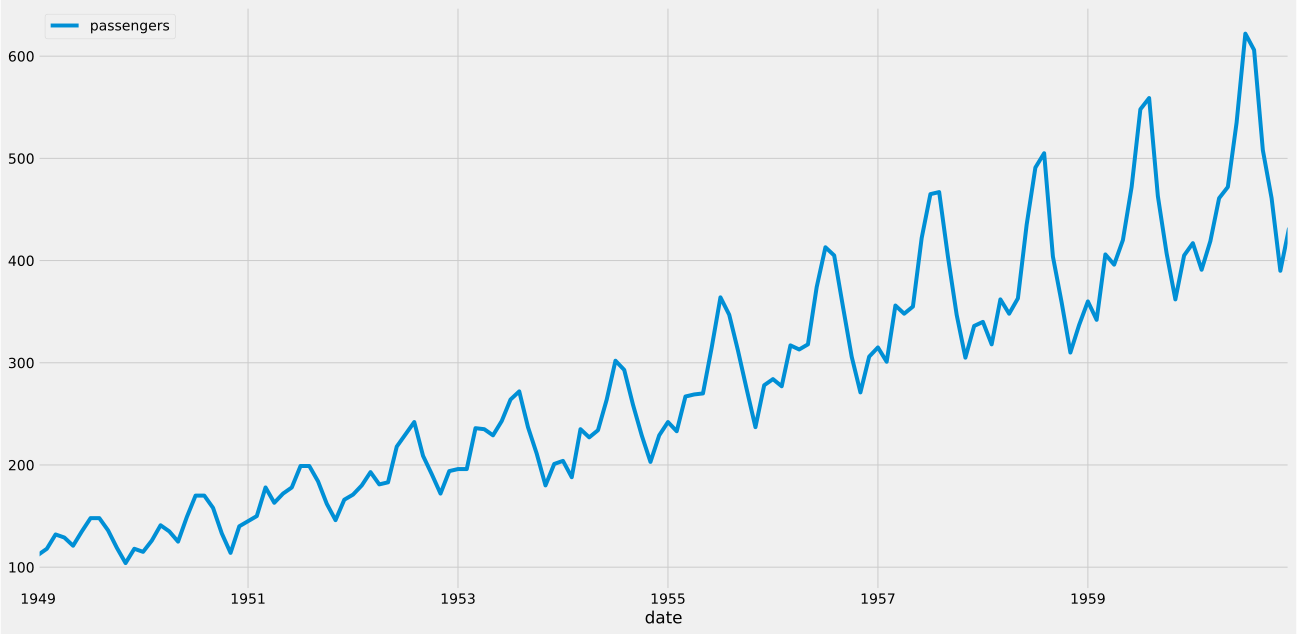

In [45]:
series = pd.read_csv(CFG.data_path / 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

Let's start with a basic additive decomposition:

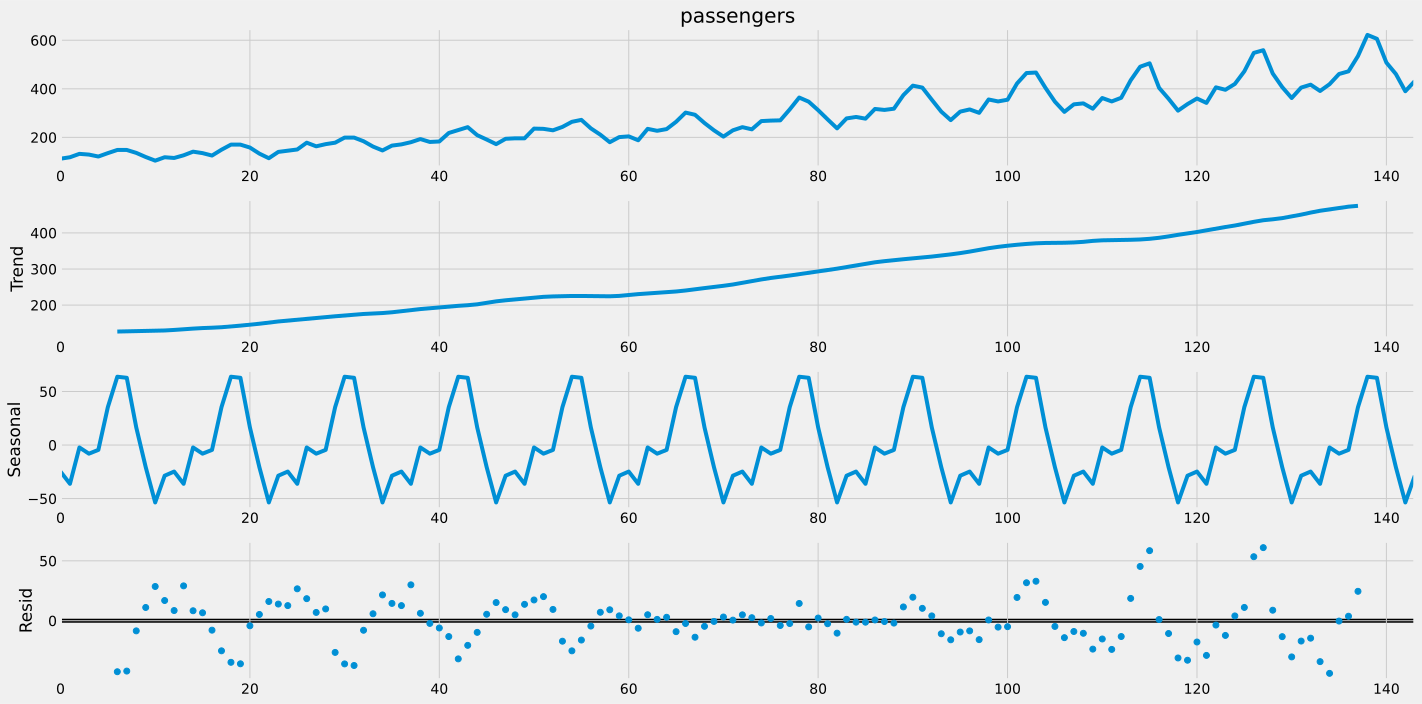

In [48]:
# decomposition
decomposition = seasonal_decompose(series["passengers"], model="additive", period=12) 
figure = decomposition.plot()
plt.show()

Trend and seasonality are behaving more or less in line with expectations, but the behavior of the residuals is clearly not consistent over time (average level of oscillations in the middle of the sample is very different than on either end). Note that this is not noise, since there is structure in the residuals.

While there are many possible reasons, one quick explanation is the additive vs multiplicative relationship between the series components &mdash; which is something we can examine quickly:

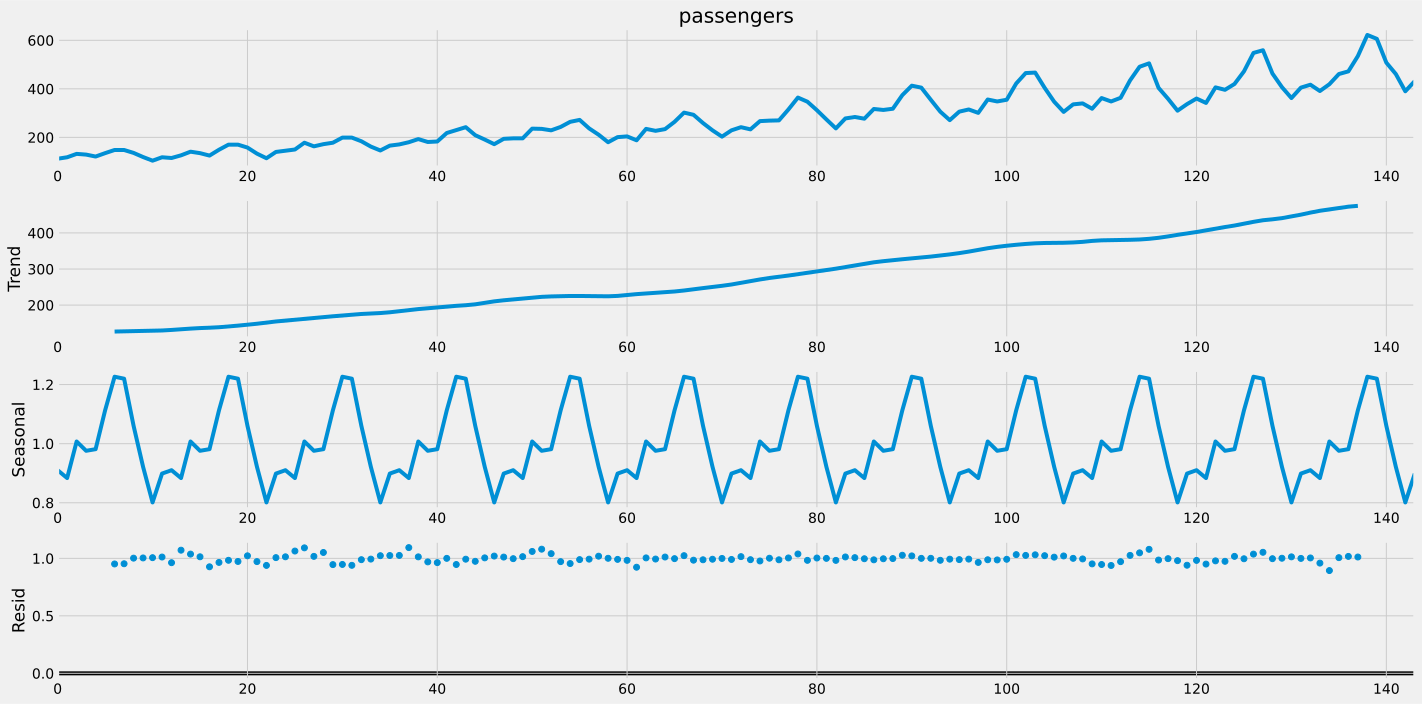

In [49]:
# decomposition
decomposition = seasonal_decompose(series["passengers"], model="multiplicative", period=12) 
figure = decomposition.plot()
plt.show()

Not much of a qualitative change in trend and seasonality components, but the residuals looks much more stable around a constant level &mdash; such phenomenon does not of course imply stationarity by itself, but at least a clear signal in the opposite direction is not there anymore. Here stationarity means that the underlying stochastic processes is independent of time.

#### Changes in level of savings in the US

Let's check how does seasonal decomposition work with some other popular datasets:

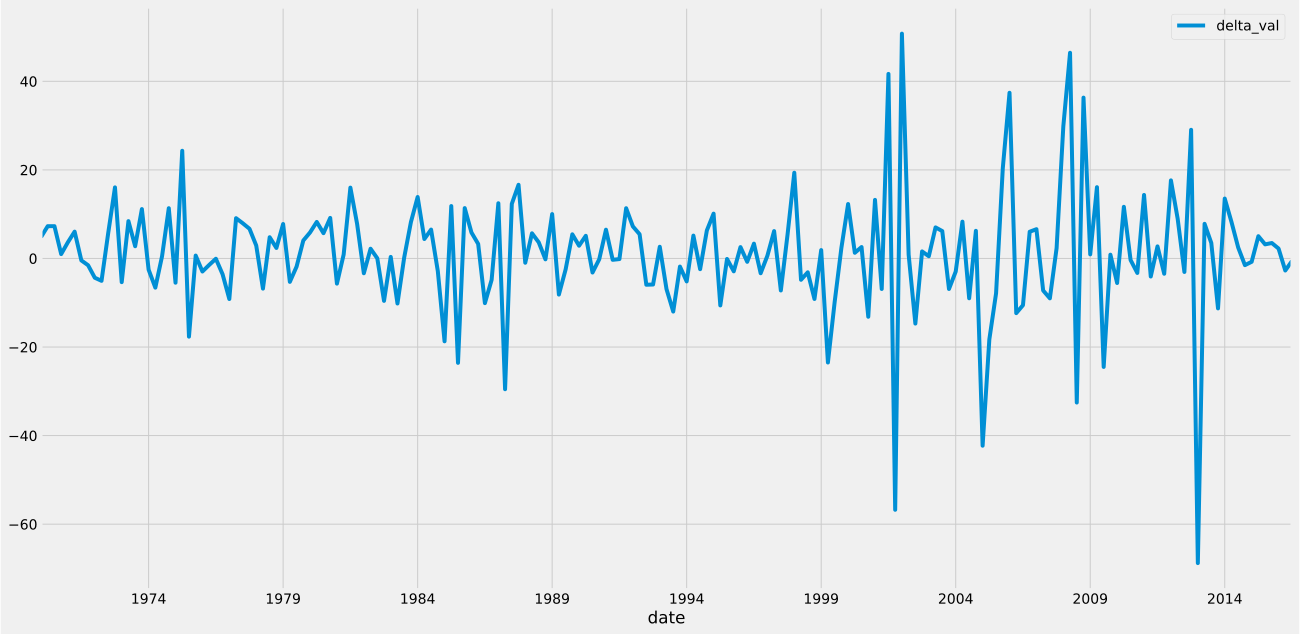

In [53]:
series = pd.read_csv(CFG.data_path / 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

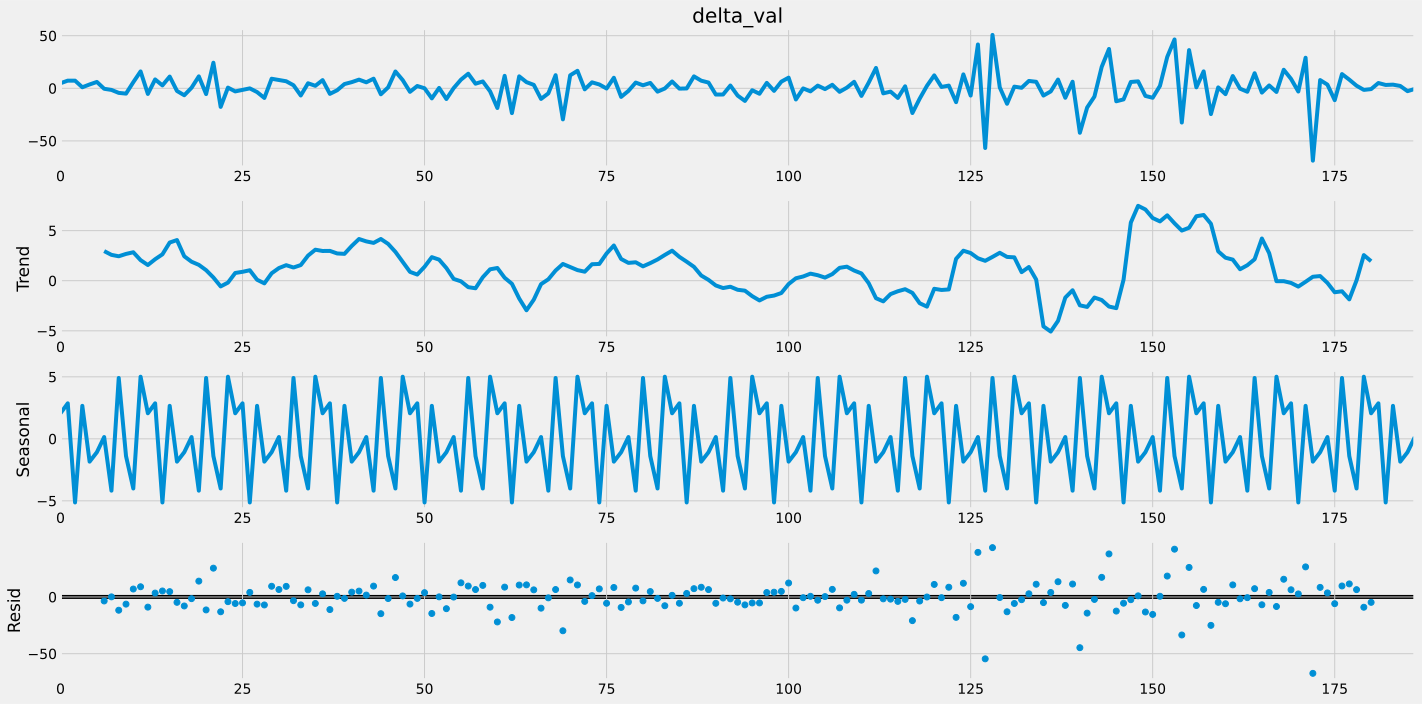

In [56]:
decomposition = seasonal_decompose(series["delta_val"], model="additive", period=12) 
figure = decomposition.plot()
plt.show()

#### Annual averages of the daily sunspot areas

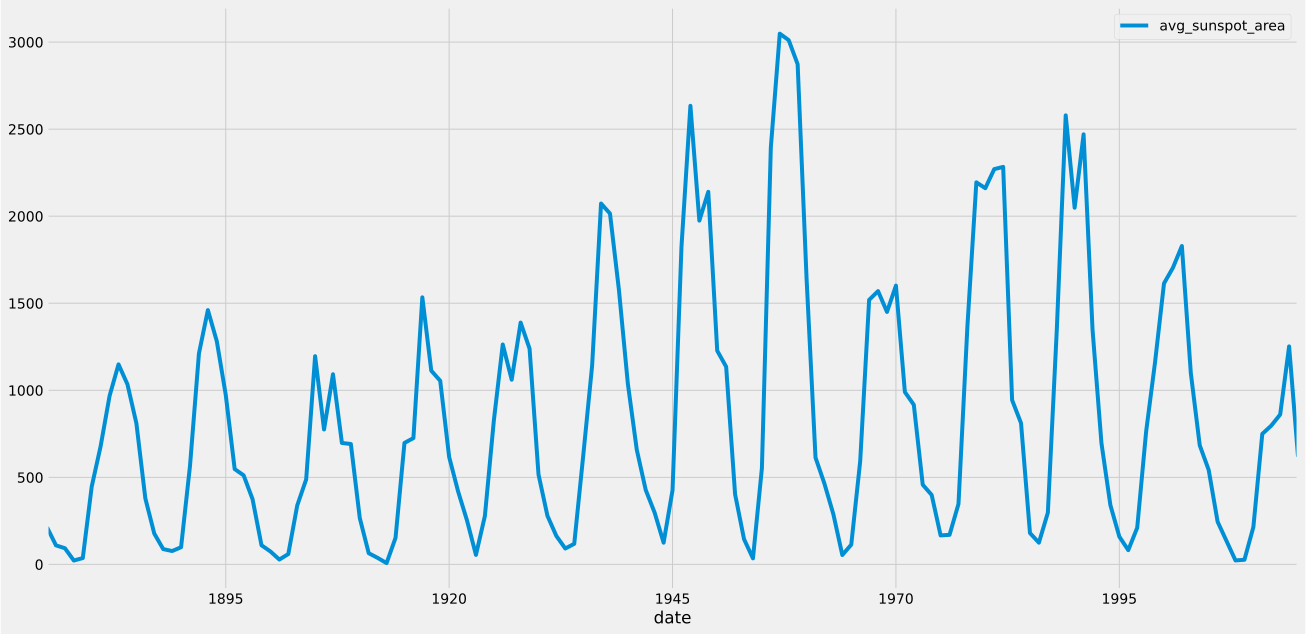

In [65]:
series = pd.read_csv(CFG.data_path / 'sunspots.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

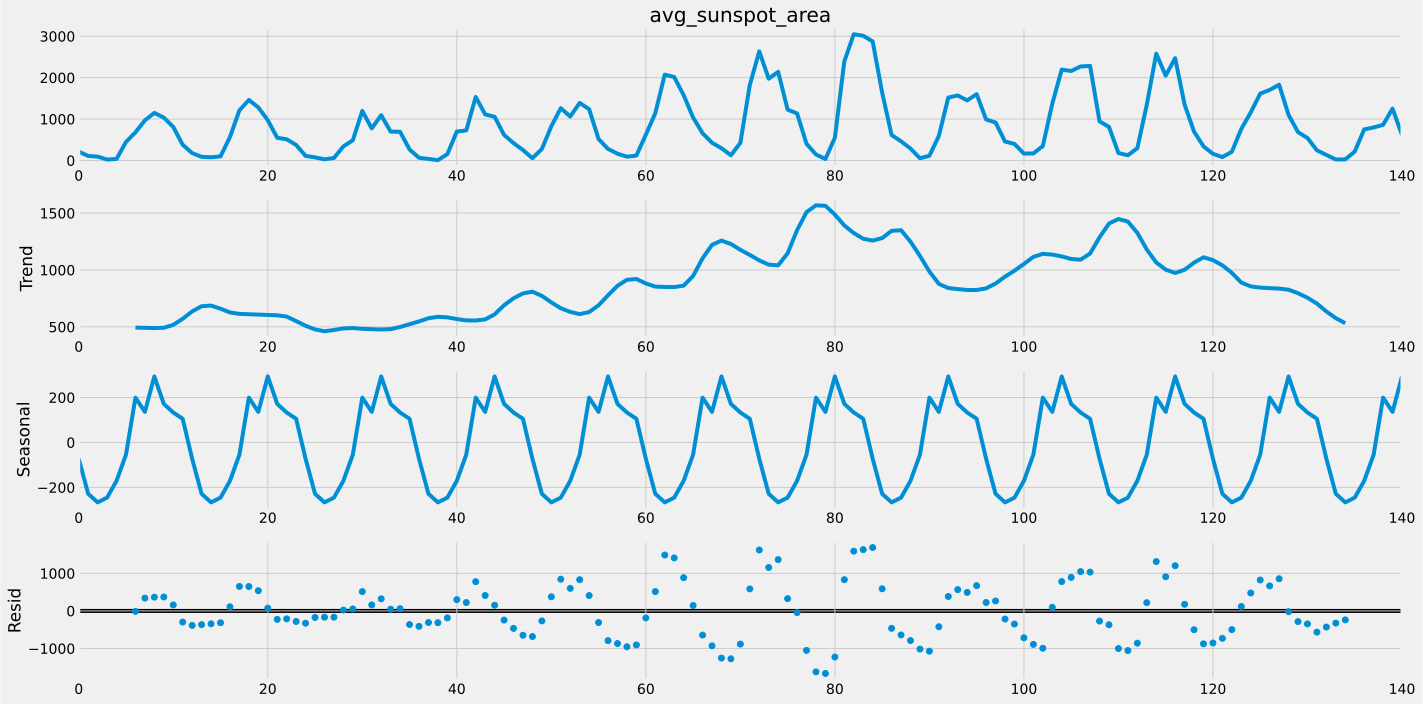

In [66]:
decomposition = seasonal_decompose(series["avg_sunspot_area"], model="additive", period=12) 
figure = decomposition.plot()
plt.show()

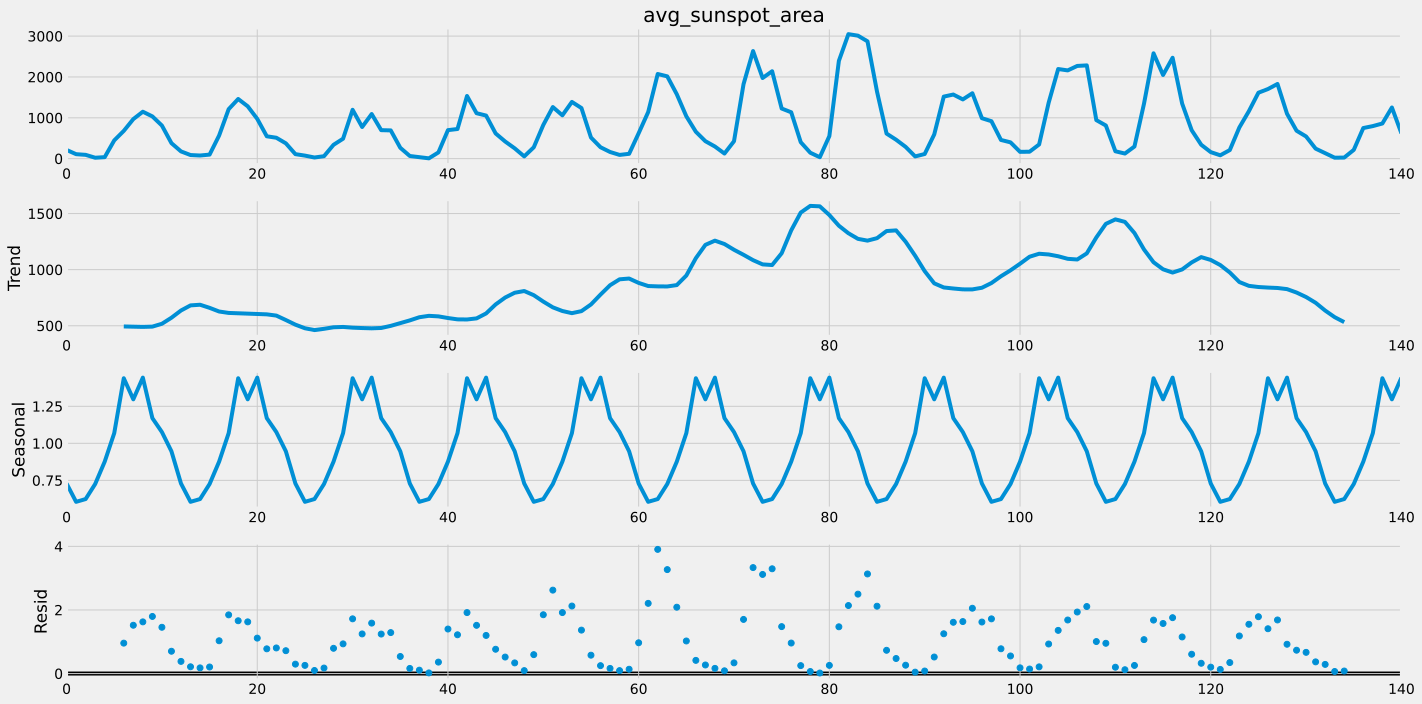

In [67]:
decomposition = seasonal_decompose(series["avg_sunspot_area"], model="multiplicative", period=12) 
figure = decomposition.plot()
plt.show();

As we can see, changing the decomposition type to multiplicative alleviates the problem with residual behavior, but only to a certain degree &mdash; the pattern is still not consistent, with increase in the amplitude in the middle of the sample. This demonstrates that while seasonal decomposition is a fast tool, it has severe limitations when dealing with more sophisticated data generating processes.

## Dependency

The only way to succesful prediction is if past values of a series carry some information about the future behavior &mdash; in other words, if the present values are dependent on the past. A fast &mdash; and therefore very popular &mdash; manner of examining this dependence are the autocorrelation and partial autocorrelation functions, which are defined below:



Suppose a random process has a mean function $\mu_t = \mathbb E[X_t]$ at each time $t,$ then the **autocovariance function** is defined by 

$$\gamma(s, t) = \textsf{Cov}(X_s, X_t) = \mathbb E[X_s X_t] - \mathbb E[X_s] \mathbb E[X_t]$$

at two time points $s$ and $t.$ This leads to the following two definitions. The **autocorrelation function** (**ACF**) is defined at each time point $t$ and lag $\tau$ is given by

$$\rho(t, \tau) = \textsf{Cor}(X_t, X_{t+\tau}) = \dfrac{\textsf{Cov}(X_t, X_{t+\tau})}{\sqrt{\textsf{Var}(X_t)} \sqrt{\textsf{Var}(X_{t+\tau})}}.$$

These two functions measure the covariance / correlation of the random process $X_t$ with itself at different time points. Finally, the **partial autocorellation function** (**PACF**) is defined as 

$$\phi(t, \tau) = \textsf{Cor}(X_t, X_{t+\tau} | X_{t+1}, \ldots, X_{t+\tau-1}).$$

An intuitive way to think about it is that ACF at lag $\tau$ measures a linear dependence between $X_t$ and $X_{t+\tau},$ while PACF captures the dependence between those values **correcting** for all the intermediate effects.

## Stationarity

To define things more formally, a stationary time series is one whose unconditional joint probability distribution does not change when shifted in time. This implies that parameters such as mean and variance also do not change over time.

Since stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data are often transformed to become stationary. A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time; the same holds true for a stationary process with an added cyclical component.

The core idea is that it's much easier to model dynamic behavior over time if the statistical properties do not change: oscillations happen around the same level, the amplitude does not change too much etc (in other words, the probability distribution of $X_t$ is the same as the distribution of $X_{t + \tau}$) &mdash; such models are well understood. Algorithms are likely to yield better predictions if we apply them to stationary processes, because we do not need to worry about e.g. concept drift between our training and test sets.

If we are dealing with a process that does not adhere to those characteristics, we can either try and capture them directly or transform it in such a manner that it can be considered stationary.



Below we plot a few examples of stationary and non-stationary series, starting with the simplest non-trivial stationary series: Gaussian white noise.

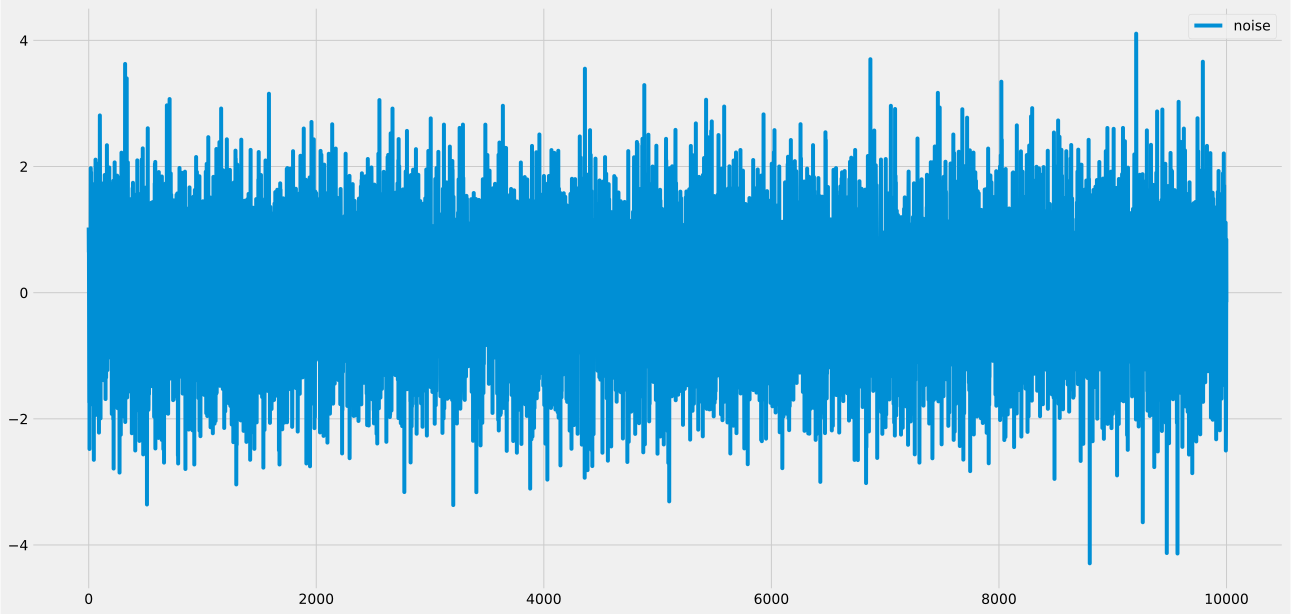

In [69]:
xseries = pd.DataFrame(data = np.random.normal(0, 1, 10000), columns = ['noise'] )
xseries.plot();

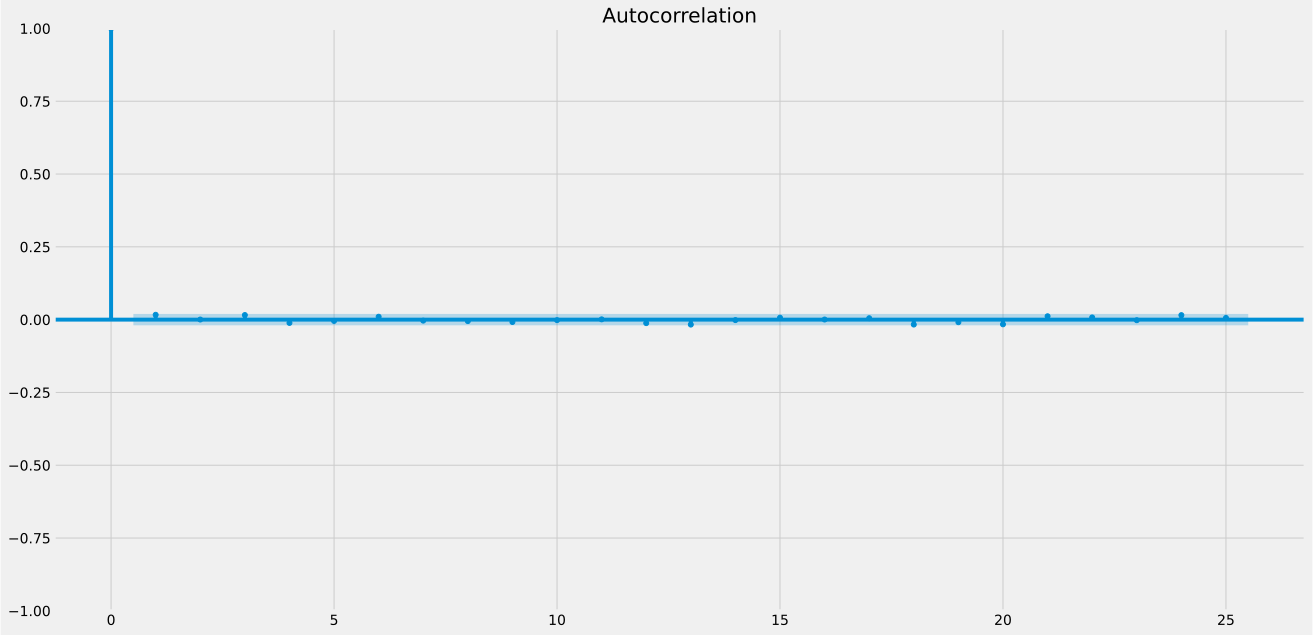

In [71]:
plot_acf(xseries['noise'], lags=25);

/Users/particle1331/miniforge3/envs/ml/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


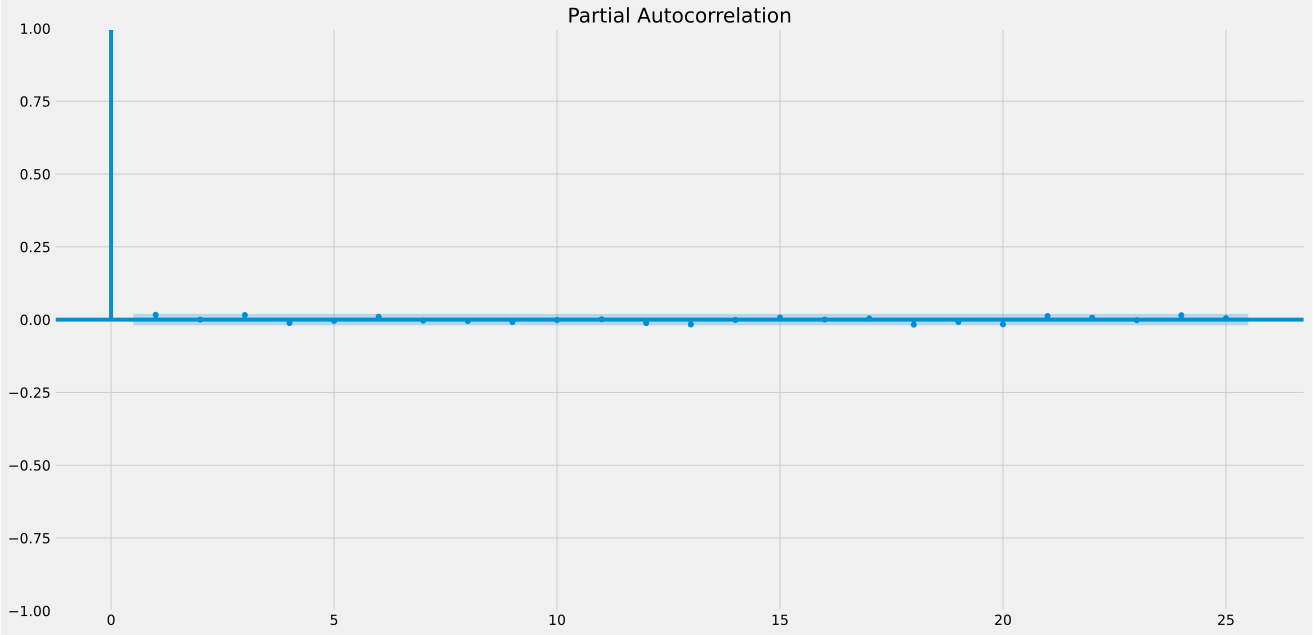

In [75]:
plot_pacf(xseries['noise'], lags=25);

For a slightly more interesting example (of non-stationary behavior), we can examine the passengers dataset:

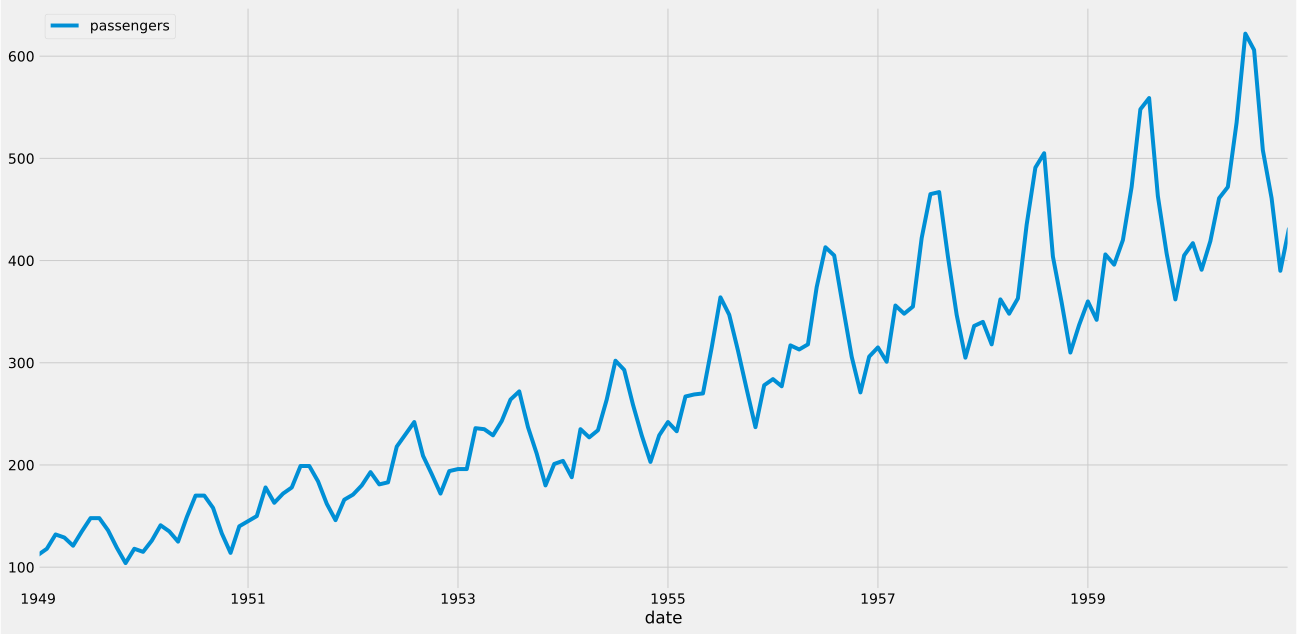

In [78]:
# Non-stationary example
series = pd.read_csv(CFG.data_path / 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot();

The stationarity of a series can be checked by examining the distribution of the series: we split the series into 2 contiguous parts and compute the summary statistics like the mean, variance and the autocorrelation. If the stats are quite different, then the series is not likely to be stationary.

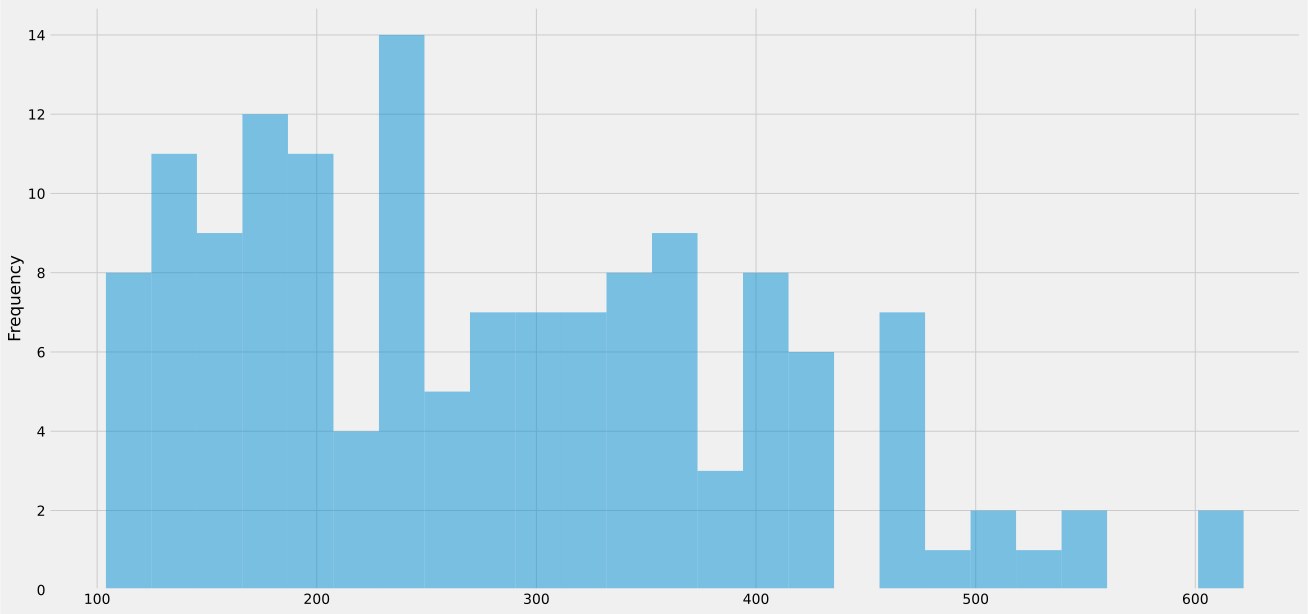

In [79]:
series['passengers'].plot.hist(bins=25, alpha=0.5);

In [87]:
X = series.passengers.values
split =  int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean')
print('chunk1: %.2f \nchunk2: %.2f' % (mean1, mean2))
print('\nvariance')
print('chunk1: %.2f \nchunk2: %.2f' % (var1, var2))

mean
chunk1: 182.90 
chunk2: 377.69

variance
chunk1: 2244.09 
chunk2: 7367.96


The values are clearly very different across the two data subsets, which strongly suggests non-stationarity. However, visual inspection is not what one would could a rigorous criterion &mdash; so let's define things in a formal manner.

### (A little bit of) theory

Given a stochastic process  $\{X_t\}$ and CDF $F_X,$ a process is strictly **stationary** iff 

$$F_X(X_{t_1}, \ldots, X_{t_n}) = F_X(X_{t_1 + \tau}, \ldots, X_{t_n + \tau})$$

The definition is very powerful (if we know a cdf of a distribution, we can infer everything) &mdash; however, it is not possible to verify in practice. For that reason, a less strict variant has been introduced: **weak** (or **second order**) **stationarity**: a process is weakly stationary if it satisfies the following conditions: 

* $\mu_t = \mu_{t + \tau}$

* $\gamma(s, t) = \gamma(s - t, 0)$

* $\sigma^2_{X_t} < \infty$

These conditions imply that $X_t$ has constant mean, covariance only depends on distance in time between variables

* constant mean
* 
* autocorrelation: 

$$\rho (0, \tau) = \dfrac{\gamma(\tau, 0)}{\gamma(0, 0)}$$

So how can we turn a non-stationary series into a stationary one? Popular transformations include (but are not limited to!):

* differencing the series
* taking the log of the series
* power transforms

#### Differencing